In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pynvml


In [2]:
# Initialiser pynvml pour la mesure de l'énergie
pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)  # GPU 0

# Configuration GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TRAIN_DIR = '/home/dieudo/Projects/Project_Neuro/Fer_Neuromorphique/data/train'
TEST_DIR = '/home/dieudo/Projects/Project_Neuro/Fer_Neuromorphique/data/test'

# Chargement des données
def create_dataframe(dir):
    image_paths = []
    labels = []
    for label in os.listdir(dir):
        for image_name in os.listdir(os.path.join(dir, label)):
            image_paths.append(os.path.join(dir, label, image_name))
            labels.append(label)
    return pd.DataFrame({'image': image_paths, 'label': labels})

train_df = create_dataframe(TRAIN_DIR)
test_df = create_dataframe(TEST_DIR)

# Encodage des labels
le = LabelEncoder()
train_df['label'] = le.fit_transform(train_df['label'])
test_df['label'] = le.transform(test_df['label'])
num_classes = len(le.classes_)

# Prétraitement des images
data_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48, 48)),
    transforms.ToTensor()
])


In [3]:

# Création de la classe Dataset
class FacialExpressionDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image, label

# Création des DataLoader
batch_size = 64
train_dataset = FacialExpressionDataset(train_df, transform=data_transform)
test_dataset = FacialExpressionDataset(test_df, transform=data_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
# Chargement de ResNet 18 pré-entraîné et adaptation
model = models.resnet18(pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Configuration de l'optimiseur et de la fonction de perte
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

/home/dieudo/Projects/Project_Neuro/Fer_Neuromorphique/env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dieudo/Projects/Project_Neuro/Fer_Neuromorphique/env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:

# Listes pour stocker les données pour les graphiques
loss_values = []
accuracy_values = []
power_usage = []

# Entraînement du modèle avec enregistrement des métriques
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        energy_consumed = 0.0

        for images, labels in train_loader:
            # Mesure de la puissance initiale
            power_start = pynvml.nvmlDeviceGetPowerUsage(handle)

            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            
            # Calcul de la précision pour le batch
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Mesure de la puissance finale et calcul de l'énergie consommée
            power_end = pynvml.nvmlDeviceGetPowerUsage(handle)
            energy_batch = (power_end - power_start) / 1000  # Convertir en watts
            energy_consumed += energy_batch

        # Calcul de la perte et de la précision pour l'époque
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = 100 * correct / total
        avg_energy_consumed = energy_consumed / len(train_loader)  # Consommation moyenne par lot
        
        # Enregistrer les valeurs pour le tracé
        loss_values.append(epoch_loss)
        accuracy_values.append(epoch_accuracy)
        power_usage.append(avg_energy_consumed)
        
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Energy: {avg_energy_consumed:.2f}W')

In [6]:
# Sauvegarde du modèle
def save_model(model, path="/home/dieudo/Projects/Project_Neuro/Fer_Neuromorphique/training/resultats/cnn18_model.pth"):
    torch.save(model.state_dict(), path)
    print(f"Modèle sauvegardé sous {path}")

# Chargement du modèle
def load_model(path="/home/dieudo/Projects/Project_Neuro/Fer_Neuromorphique/training/resultats/cnn18_model.pth"):
    model = models.resnet18(pretrained=False)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(torch.load(path, map_location=device))
    model = model.to(device)
    model.eval()  # Mise en mode évaluation pour les prédictions
    print(f"Modèle chargé depuis {path}")
    return model

In [7]:
# Fonction pour tester avec des images individuelles
def predict_image(model, image_path):
    model.eval()
    transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((48, 48)),
        transforms.ToTensor()
    ])
    
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)  # Ajouter une dimension pour le batch et transférer sur le GPU
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        label = le.classes_[predicted.item()]
    
    plt.imshow(image.cpu().squeeze(), cmap='gray')
    plt.title(f"Prédiction du modèle : {label}")
    plt.axis('off')
    plt.show()

In [8]:
# Évaluation du modèle et génération de la matrice de confusion
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Matrice de confusion
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    ConfusionMatrixDisplay(conf_matrix, display_labels=le.classes_).plot(cmap="Blues", ax=plt.gca())
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

In [9]:

# Entraînement du modèle
train_model(model, train_loader, criterion, optimizer, epochs=90)

Epoch [1/90], Loss: 1.7975, Accuracy: 28.75%, Energy: 0.02W
Epoch [2/90], Loss: 1.4661, Accuracy: 43.50%, Energy: 0.00W
Epoch [3/90], Loss: 1.3304, Accuracy: 48.88%, Energy: -0.01W
Epoch [4/90], Loss: 1.2687, Accuracy: 51.98%, Energy: -0.01W
Epoch [5/90], Loss: 1.2313, Accuracy: 53.28%, Energy: -0.01W
Epoch [6/90], Loss: 1.1699, Accuracy: 55.94%, Energy: -0.02W
Epoch [7/90], Loss: 1.0990, Accuracy: 58.95%, Energy: -0.01W
Epoch [8/90], Loss: 1.0246, Accuracy: 61.95%, Energy: -0.02W
Epoch [9/90], Loss: 0.9312, Accuracy: 65.66%, Energy: -0.02W
Epoch [10/90], Loss: 0.8871, Accuracy: 66.85%, Energy: -0.01W
Epoch [11/90], Loss: 0.7583, Accuracy: 72.33%, Energy: -0.02W
Epoch [12/90], Loss: 0.6103, Accuracy: 77.85%, Energy: -0.01W
Epoch [13/90], Loss: 0.5037, Accuracy: 81.94%, Energy: -0.02W
Epoch [14/90], Loss: 0.4389, Accuracy: 84.31%, Energy: -0.02W
Epoch [15/90], Loss: 0.3639, Accuracy: 87.26%, Energy: -0.01W
Epoch [16/90], Loss: 0.2626, Accuracy: 90.74%, Energy: -0.01W
Epoch [17/90], Loss

Modèle sauvegardé sous /home/dieudo/Projects/Project_Neuro/Fer_Neuromorphique/training/resultats/cnn18_model.pth


/home/dieudo/Projects/Project_Neuro/Fer_Neuromorphique/env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_6459/1316194228.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via 

Modèle chargé depuis /home/dieudo/Projects/Project_Neuro/Fer_Neuromorphique/training/resultats/cnn18_model.pth


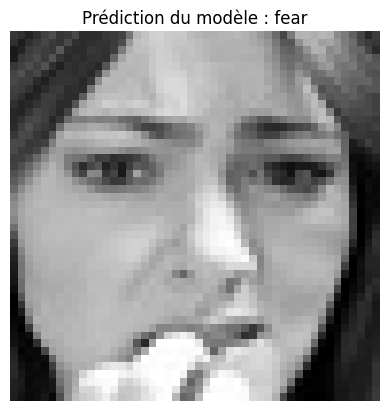

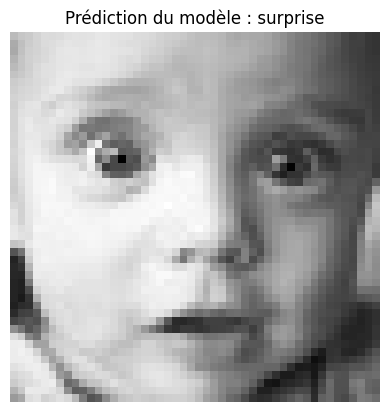

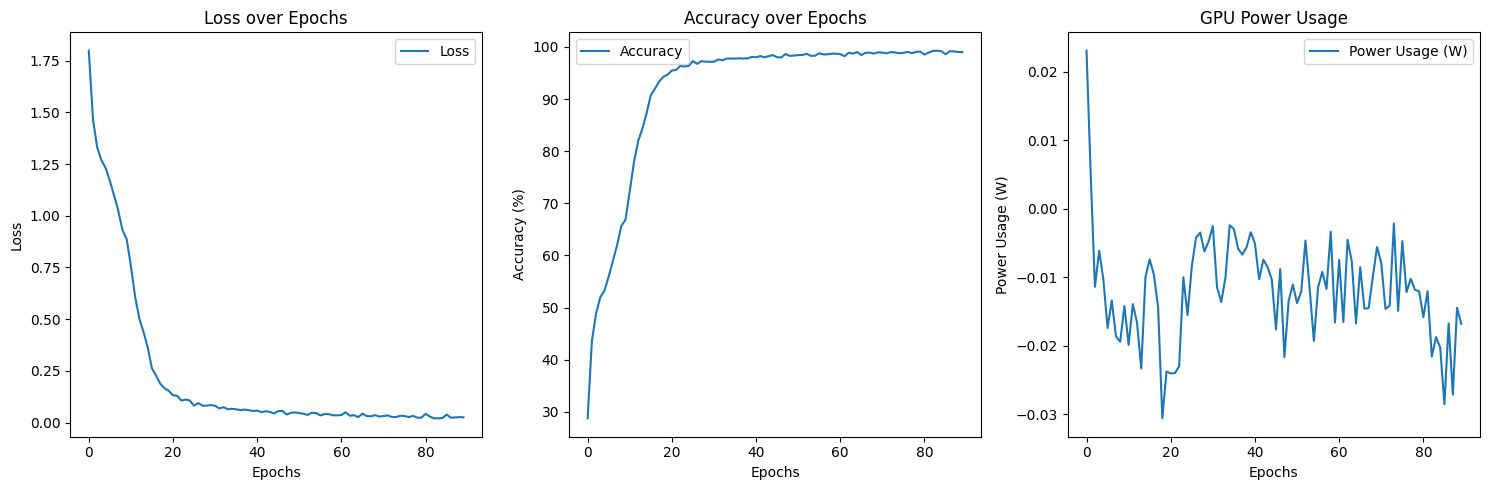

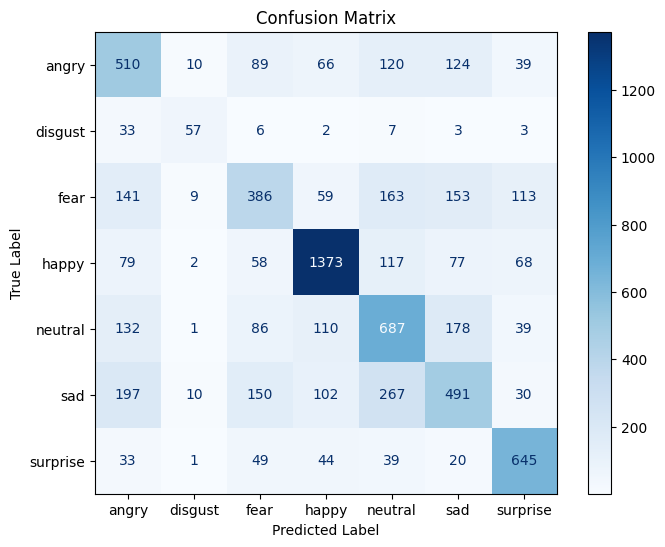

In [10]:


# Sauvegarder le modèle après l'entraînement
save_model(model, "/home/dieudo/Projects/Project_Neuro/Fer_Neuromorphique/training/resultats/cnn18_model.pth")

# Charger le modèle pour des tests avec des images spécifiques
loaded_model = load_model("/home/dieudo/Projects/Project_Neuro/Fer_Neuromorphique/training/resultats/cnn18_model.pth")
predict_image(loaded_model, '/home/dieudo/Projects/Project_Neuro/Fer_Neuromorphique/data/train/fear/Training_303571.jpg')
predict_image(loaded_model, '/home/dieudo/Projects/Project_Neuro/Fer_Neuromorphique/data/train/surprise/Training_353184.jpg')

# Afficher les graphiques de la perte, de la précision et de la consommation énergétique
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Courbe de perte
axs[0].plot(loss_values, label="Loss")
axs[0].set_title("Loss over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()

# Courbe de précision
axs[1].plot(accuracy_values, label="Accuracy")
axs[1].set_title("Accuracy over Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy (%)")
axs[1].legend()

# Courbe de consommation d'énergie
axs[2].plot(power_usage, label="Power Usage (W)")
axs[2].set_title("GPU Power Usage")
axs[2].set_xlabel("Epochs")
axs[2].set_ylabel("Power Usage (W)")
axs[2].legend()

plt.tight_layout()
plt.show()

# Évaluation finale et affichage de la matrice de confusion
evaluate_model(model, test_loader)

# Fermer pynvml
pynvml.nvmlShutdown()
